Goal: Finding the probability a customer to be fraud

Method: Hybrid of supervised and unsupervisied learning

Expected: Ranking of probabilities of each customer cheated

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show
from keras.models import Sequential
from keras.layers import Dense

In [55]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
x = dataset.iloc[:, :-1].values # note thatg only x will be used to train
y = dataset.iloc[:,-1].values # y is just used for comparison later

sc = MinMaxScaler(feature_range=(0, 1))
sc.fit_transform(x)

# x, y = size of the SOM grid
# input length is the number of features (14 metrics in dataset + 1st column which is Customer ID)
# sigma is the neighbourhood radius
# learning rate determines the speed of convergence.
som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)
# initialize the weights
som.random_weights_init(x)

In [56]:
# train the som
som.train_random(data=x, num_iteration=1000)

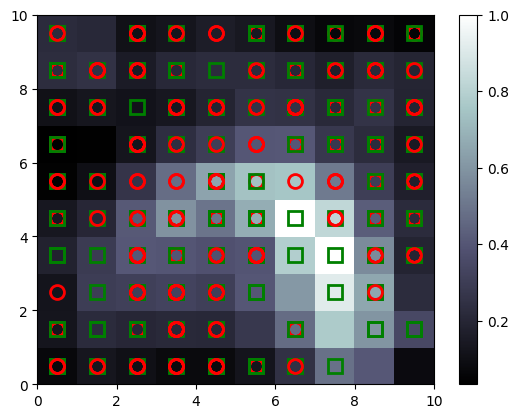

In [57]:
bone() # creates an empty window
pcolor(som.distance_map().T) # plots the SOM
colorbar() # specifies legend
# add markers everywhere to show customer approval status (winning node)
markers = ['o', 's'] # o - circle [0], s - square [1]
colors = ['r', 'g'] # r - red, g - green

for i, j in enumerate(x): # i - index of customers, j - vectors of customers at every iteration
    # get the winning node for the respective customer
    w = som.winner(j)
    plot(w[0] + 0.5, 
         w[1] + 0.5, 
         markers[y[i]], 
         markeredgecolor = colors[y[i]], 
         markerfacecolor = 'None',
         markersize = 10, 
         markeredgewidth = 2) # the marker is placed on the center of the coordinates.
    
show()

In [47]:
mappings = som.win_map(x)

In [58]:
mappings = som.win_map(x) # dictionary
frauds = np.concatenate((mappings[(1, 5)], mappings[(0, 6)]), axis=0) # using the coordinates of the cell in the map that corresponds to value 1 in colormap., 
frauds = sc.inverse_transform(frauds)


In [59]:
len(frauds)

6

Going from unsupervised to supervised deep learning model

In [60]:
# creating matrix of features
customers = dataset.iloc[:, 1:].values
# dependent variable - binary outcome (1 - fraud, 0 - not fraud)
is_fraud = np.zeros(len(dataset))

for i in range(len(dataset)):
    if (dataset.iloc[i, 0] in frauds):
        is_fraud[i] = 1


In [61]:
is_fraud

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Training the ANN

In [65]:
ss = StandardScaler()
customers = ss.fit_transform(customers)

classifier = Sequential()
classifier.add(Dense(units = 2, kernel_initializer='uniform', activation='relu', input_dim = 15))
classifier.add(Dense(units = 1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
classifier.fit(customers, is_fraud, batch_size=1, epochs=5)

Epoch 1/5
690/690 [==============================] - 3s 2ms/step - loss: 0.4921 - accuracy: 0.9971
Epoch 2/5
690/690 [==============================] - 1s 1ms/step - loss: 0.1026 - accuracy: 1.0000
Epoch 3/5
690/690 [==============================] - 0s 609us/step - loss: 0.0208 - accuracy: 1.0000
Epoch 4/5
690/690 [==============================] - 0s 600us/step - loss: 0.0083 - accuracy: 1.0000
Epoch 5/5
690/690 [==============================] - 0s 605us/step - loss: 0.0042 - accuracy: 1.0000


In [72]:
# Predicted probabilities
y_pred = classifier.predict(customers)
# mapping customer ID to predicted probability
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1) # horizontal concatenation
# sorting based on probability
y_pred = y_pred[y_pred[:, 1].argsort()]

22/22 [==============================] - 0s 749us/step


In [73]:
y_pred

array([[1.57997850e+07, 2.94923939e-05],
       [1.56548590e+07, 3.70241833e-05],
       [1.57250280e+07, 6.09668641e-05],
       ...,
       [1.57053790e+07, 2.37768088e-02],
       [1.57440440e+07, 2.40509044e-02],
       [1.56647930e+07, 3.34406942e-02]])

In [74]:
len(y_pred)

690